# ViT Classification using backbone stuff we did 





In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
  
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  2.2.0+cpu
Torchvision Version:  0.17.0+cpu


## Step 0: Downloading the dataset.



In [5]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2024-02-08 13:17:12--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  62.0MB/s    in 8.7s    

2024-02-08 13:17:21 (58.6 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [6]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [7]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    composed_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.ToTensor(), transforms.Normalize(mean,std)])

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [8]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


In [14]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd76432b140>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fd764328620>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd76432ac00>}

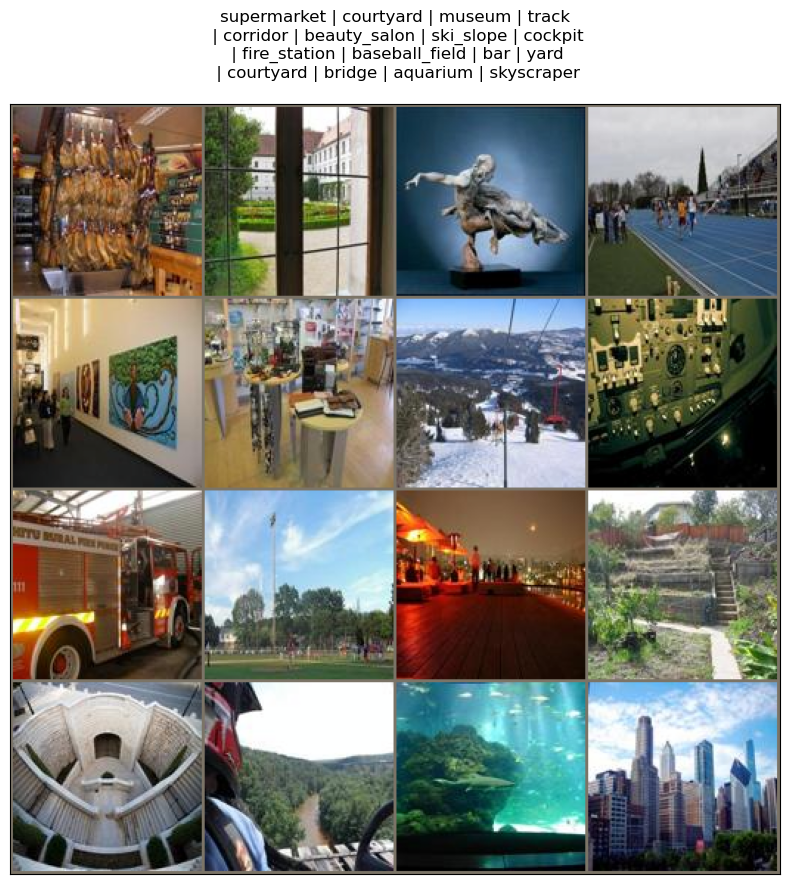

In [9]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

In [10]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    """
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

# Vit Network Backbones

In [ ]:
# class PatchEmbed(nn.Module):
#   def __init__(self, img_size, patch_size=16, in_channels=3, embed_channels=768):
#     super().__init__()
#     self.org_img = (img_size,img_size) #Writing image sizes as a tuple of dimensions (H*W) 
#     self.patch = (patch_size,patch_size) #Writing image sizes as a tuple of dimensions (H*W) 
#     self.num_patches = self.org_img[0]//self.patch[0] * self.org_img[1]//self.patch[1] #Calculating number of patches that will be formed with the dimensions fed into this function
#     self.project = nn.Conv2d(in_channels, embed_channels, kernel_size=self.patch[0], stride=self.patch[0], padding=self.patch[0]//2) #Defining a convolution to get the expected number of output channels

#   def forward(self, input):
#     output = self.project(input) #Applying the convolution to get the expected number of output channels
#     output = output.flatten(2).transpose(1,2) #Arranging the patches in the required format
#     return output

In [8]:
# USING PATCH EMBED FUNCTION FROM PUBLISHED CODE, NOT NITHINS WORK
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_channels=768, ratio=1):
        super().__init__()
        img_size = (img_size,img_size)
        patch_size = (patch_size,patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (ratio ** 2)
        self.patch_shape = (int(img_size[0] // patch_size[0] * ratio), int(img_size[1] // patch_size[1] * ratio))
        self.origin_patch_shape = (int(img_size[0] // patch_size[0]), int(img_size[1] // patch_size[1]))
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_channels, embed_channels, kernel_size=patch_size, stride=(patch_size[0] // ratio), padding=4 + 2 * (ratio//2-1))

    def forward(self, input):
        output = self.proj(input)
        output = output.flatten(2).transpose(1, 2)
        return output

In [9]:
class attentionBlock(nn.Module):
  def __init__(self, num_embedding, num_heads = 12, qkv_bias=True, attention_drop=0.0, projection_drop=0.0):
    super().__init__()
    self.num_heads = num_heads # total heads
    self.input_dim = num_embedding #input dim for attention heads
    self.head_dim = num_embedding // num_heads # dividing dimensionaly such that output attention head matches input dim
    total_head = self.head_dim * self.num_heads
    self.scale = self.head_dim ** -0.5 # preventing vanishing gradients in softmax etc...
    self.qkv = nn.Linear(self.input_dim,self.input_dim*3, bias=qkv_bias) # generate query key and value QKV
    self.drop1 = nn.Dropout(attention_drop) # dropout after attention
    self.project = nn.Linear(self.input_dim, self.input_dim) # linear layer
    self.drop2 = nn.Dropout(projection_drop) # dropout to prevent overfitting

  def forward(self, input):
    batch_size, tocken_size, embed_size = input.shape #num_tockens = num_patches+1
    QKV = self.qkv(input) # query key and values
    QKV = QKV.reshape(batch_size, tocken_size, 3, self.num_heads, self.head_dim) # (batch_size, num_tokens, 3, num_heads, head_dim)
    QKV = QKV.permute(2,0,3,1,4) # (3, batch_size, num_heads, num_tokens, head_dim)
    Q, K, V = QKV[0], QKV[1], QKV[2]
    K_tranpose = K.transpose(-2,-1) # (batch_size, num_heads, dead_dim, num_tokens)
    product = (Q @ K_tranpose) * self.scale # (batch_size, num_heads, num_tokens, num_tokens)
    attention = product.softmax(dim=-1) # (batch_szie, num_heads, num_toekns, num_tokens)
    attention = self.drop1(attention)
    average = attention @ V # (batch_size, num_heads, num_tokens, head_dim)
    average = average.transpose(1,2) # (batch_szie, num_tokens, num_heads, head_dim)
    average = average.flatten(2) # (batchsize, num_tokens, original dim)
    output = self.project(average) # (batch_szie, num_tokens, iriginal dim)
    output = self.drop2(output) # final dropout
    return output

In [10]:
class FFN(nn.Module):
  def __init__(self, input_features, hidden_features, output_features, drop_rate=0.0):
    super().__init__()
    self.fc1 = nn.Linear(input_features, hidden_features)
    self.activate = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, output_features)
    self.drop = nn.Dropout(drop_rate)

  def forward(self, input):
    output = self.fc1(input)
    output = self.activate(output)
    output = self.drop(output)
    output = self.fc2(output)
    output = self.drop(output)
    return output

In [11]:
class transformerBlock(nn.Module):
  def __init__(self, num_embedding=768, num_heads=12, hiddenFactor = 4.0, qkv_bias=True, attention_drop = 0.0, projection_drop = 0.0):
    super().__init__()
    self.LN1 = nn.LayerNorm(num_embedding)
    self.attention = attentionBlock(num_embedding, num_heads=num_heads, qkv_bias=qkv_bias, attention_drop=attention_drop, projection_drop=projection_drop )
    self.LN2 = nn.LayerNorm(num_embedding)
    self.ffn = FFN(input_features = num_embedding, hidden_features=int(num_embedding*hiddenFactor), output_features = num_embedding)

  def forward(self, input):
    input = input + self.attention(self.LN1(input))
    output = input + self.ffn(self.LN2(input))
    return output

In [12]:
class visionNetwork(nn.Module):
  def __init__(self, image_size=224, patch_size=16, output_classes=100, embed_dim=768, L = 12, num_heads=12, hiddenFactor=4.0, qkv_bias=True, attention_drop=0.0, projection_drop=0.0, init_weights=True):
    super().__init__()
    # vision transformer
    self.patchEmbedding = PatchEmbed(img_size=image_size, patch_size=patch_size, in_channels=3, embed_channels=embed_dim) 
    self.classToken = nn.Parameter(torch.zeros(1,1,embed_dim))
    self.positionToken = nn.Parameter(torch.zeros(1,1+self.patchEmbedding.num_patches, embed_dim))
    self.positionDrop = nn.Dropout(p=projection_drop)
    self.transformerList = nn.ModuleList([transformerBlock(num_embedding=embed_dim, num_heads=num_heads, hiddenFactor=4.0, qkv_bias=True, attention_drop=attention_drop, projection_drop=projection_drop) for i in range(L)]) 
    # decoder section
    self.decodeLN = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, output_classes)

    if init_weights==True:
            self._initialize_weights()


  def forward(self, input):
    batch_size = input.shape[0]
    output = self.patchEmbedding(input)
    class_token = self.classToken.expand(batch_size,-1,-1)
    output = torch.cat((class_token, output), dim=1)
    output = output + self.positionToken
    output = self.positionDrop(output)
    for transformerBlock in self.transformerList:
      output = transformerBlock(output)
    output = self.decodeLN(output)
    classPrediction = output[:, 0]
    classPrediction = self.head(classPrediction)
    return classPrediction

  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, std=.02)
              if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
              nn.init.constant_(m.bias, 0)
              nn.init.constant_(m.weight, 1.0)

In [17]:
vitnet = visionNetwork(image_size=64, patch_size=16, output_classes=100, embed_dim=768, L = 2, num_heads=12, hiddenFactor=4.0, qkv_bias=True, attention_drop=0.0, projection_drop=0.0, init_weights=True)
from torchinfo import summary
summary(model, input_size=(4, 1, 28, 28))

visionNetwork(
  (patchEmbedding): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
  )
  (positionDrop): Dropout(p=0.0, inplace=False)
  (transformerList): ModuleList(
    (0): transformerBlock(
      (LN1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): attentionBlock(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (drop1): Dropout(p=0.0, inplace=False)
        (project): Linear(in_features=768, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (LN2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): FFN(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (activate): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): transformerBlock(
      (LN1): LayerNorm((768,), eps=1e-05, elementwise_affine=

## Step 4: Build training/validation loops

You will write a function for training and validating the network. 

In [18]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """

    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss. 
    """

    criterion = nn.CrossEntropyLoss()

    return criterion

In [20]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='ViTNetwork'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train':
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  _, preds = torch.max(outputs.data,1)
                  loss = criterion(outputs,labels)
                  loss.backward()
                  optimizer.step()
                else:
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  _, preds = torch.max(outputs.data,1)
                  loss = criterion(outputs,labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 5. Train Model

In [21]:
# Number of classes in the dataset
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [22]:
# Initialize
model = vitnet.to(device)
optimizer = make_optimizer(model)

# Train the model!
trainedVIT, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='ViTNetwork')

Epoch 0/19
----------


100%|██████████| 704/704 [01:18<00:00,  8.93it/s]


train Loss: 4.0734 Acc: 0.0825


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 3.8826 Acc: 0.1054
Epoch 1/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.86it/s]


train Loss: 3.7099 Acc: 0.1315


100%|██████████| 79/79 [00:07<00:00, 10.55it/s]


val Loss: 3.6766 Acc: 0.1384
Epoch 2/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 3.5479 Acc: 0.1562


100%|██████████| 79/79 [00:08<00:00,  9.31it/s]


val Loss: 3.5788 Acc: 0.1497
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.85it/s]


train Loss: 3.4224 Acc: 0.1775


100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


val Loss: 3.5654 Acc: 0.1571
Epoch 4/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 3.3096 Acc: 0.1966


100%|██████████| 79/79 [00:07<00:00, 10.47it/s]


val Loss: 3.5743 Acc: 0.1594
Epoch 5/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.87it/s]


train Loss: 3.1860 Acc: 0.2191


100%|██████████| 79/79 [00:07<00:00, 10.44it/s]


val Loss: 3.5345 Acc: 0.1691
Epoch 6/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.63it/s]


train Loss: 3.0497 Acc: 0.2441


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 3.5645 Acc: 0.1693
Epoch 7/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.74it/s]


train Loss: 2.8852 Acc: 0.2730


100%|██████████| 79/79 [00:07<00:00, 10.69it/s]


val Loss: 3.6211 Acc: 0.1682
Epoch 8/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.81it/s]


train Loss: 2.6784 Acc: 0.3120


100%|██████████| 79/79 [00:07<00:00, 10.04it/s]


val Loss: 3.7636 Acc: 0.1636
Epoch 9/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.42it/s]


train Loss: 2.4206 Acc: 0.3651


100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


val Loss: 3.9497 Acc: 0.1605
Epoch 10/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.70it/s]


train Loss: 2.1097 Acc: 0.4364


100%|██████████| 79/79 [00:07<00:00, 10.22it/s]


val Loss: 4.1196 Acc: 0.1542
Epoch 11/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.63it/s]


train Loss: 1.7350 Acc: 0.5251


100%|██████████| 79/79 [00:07<00:00, 10.20it/s]


val Loss: 4.4471 Acc: 0.1442
Epoch 12/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.46it/s]


train Loss: 1.3347 Acc: 0.6258


100%|██████████| 79/79 [00:07<00:00, 10.41it/s]


val Loss: 4.8509 Acc: 0.1414
Epoch 13/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.69it/s]


train Loss: 0.9464 Acc: 0.7292


100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


val Loss: 5.3513 Acc: 0.1348
Epoch 14/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.68it/s]


train Loss: 0.6079 Acc: 0.8238


100%|██████████| 79/79 [00:07<00:00, 10.42it/s]


val Loss: 5.7893 Acc: 0.1330
Epoch 15/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.40it/s]


train Loss: 0.3592 Acc: 0.8962


100%|██████████| 79/79 [00:07<00:00, 10.14it/s]


val Loss: 6.2097 Acc: 0.1334
Epoch 16/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.66it/s]


train Loss: 0.2274 Acc: 0.9357


100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


val Loss: 6.6417 Acc: 0.1383
Epoch 17/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 0.0941 Acc: 0.9763


100%|██████████| 79/79 [00:07<00:00, 10.42it/s]


val Loss: 6.8625 Acc: 0.1375
Epoch 18/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.49it/s]


train Loss: 0.0317 Acc: 0.9945


100%|██████████| 79/79 [00:09<00:00,  8.57it/s]


val Loss: 6.9743 Acc: 0.1431
Epoch 19/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 0.0114 Acc: 0.9986


100%|██████████| 79/79 [00:08<00:00,  8.82it/s]

val Loss: 7.0218 Acc: 0.1477
Best val Acc: 0.169300


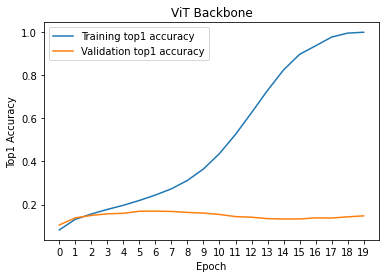

In [23]:
x = np.arange(num_epochs)
# train/val accuracies
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('ViT Backbone')
plt.show()


## Step 6. Measure top1 and top5 accuracies

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [24]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values 
    of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the 
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [25]:

trainedVIT.load_state_dict(torch.load('./weights/ViTNetwork.pth'))
test(trainedVIT, dataloaders['test'])

Top-1 accuracy 16.66%, Top-5 accuracy 40.65%
